#### Setup:

In [ ]:
import pandas as pd
import numpy as np
import math
import re
from datetime import datetime
from dateutil import relativedelta
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
pd.set_option("display.max_columns", None)

#### Import Text-Cleaned Kickstarter Dataset:

In [ ]:
kickstarter_df = pd.read_csv("03_Data Cleaning/Kickstarter_Text_Cleaned.csv", index_col=0, converters={"links_in_campaign":eval, "creator_links":eval})
print(kickstarter_df.shape)
print(len(kickstarter_df.index.unique()))
kickstarter_df.head()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (22,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(306167, 59)
306167


,url,name,blurb,state,goal,pledged,backers_count,comments_count,updates_count,category,subcategory,staff_pick,campaign_has_video,kickstarter_country,location_name,location_state,location_country,profile_changed_after_success,created_at,launched_at,state_changed_at,successful_at,deadline,updated_at,last_modification,number_of_collaborators,environmental_commitments,story,risks,links_in_campaign,number_of_images_in_campaign,number_of_videos_in_campaign,number_of_audios_in_campaign,number_of_interactives_in_campaign,creator_verified_identity,creator_has_image,creator_last_login,creator_biography,creator_facebook_authentication,creator_allows_follows,creator_backings_count,creator_projects_count,creator_location,creator_state,creator_country,number_of_rewards,reward_description,reward_highest_pledge_amount,reward_lowest_pledge_amount,reward_average_pledge_amount,number_of_limited_rewards,reward_limit_sum,reward_limit_average,number_of_shipped_rewards,number_of_restricted_shipping_rewards,reward_earliest_delivery,reward_latest_delivery,number_of_delivery_specified_rewards,creator_links
22810934,https://www.kickstarter.com/projects/cavinboun...,lights coma action.,a book to tell the story of who i was lights h...,successful,15000.0,18167.88,284,4,40,Publishing,Nonfiction,False,True,United States,"Austin, TX",Texas,United States,True,2013-10-01,2013-10-03,2013-11-02,2013-11-02,2013-11-02,2017-03-01,2018-05-24,0,[],check out the reddit ama and ask me anything....,earlier this year at the twentieth annual writ...,"[reddit.com, cavinb.wordpress.com, r20.rs6.net...",0,0,2,0,False,True,2020-08-28,in two thousand eleven i suffered a severe tra...,False,True,7,1,"Austin, TX",Texas,United States,9,a digital version of the book when it is avai...,1000.0,1.0,232.333333,3,150.0,50.00,7,0,2014-11-01,2018-10-01,9,"[feedabrain.com, adventuresinbraininjury.com]"
22821161,https://www.kickstarter.com/projects/684178251...,sentio golf putters. feel is the difference,choose the feel you want with our patented flo...,failed,50000.0,9707.00,41,0,4,Design,Product Design,False,True,United States,"Acton, MA",Massachusetts,United States,False,2015-06-08,2015-09-18,2015-11-02,NaN,2015-11-02,2016-05-20,2017-03-11,0,[],sentio putters feature a unique floating face...,high tech process although we have made severa...,[],13,0,0,0,True,True,2016-01-02,sentio golf is driven to produce the most adva...,False,True,0,1,"Acton, MA",Massachusetts,United States,8,our eternal gratitude. every little bit helps ...,1417.0,5.0,422.500000,0,0.0,0.00,7,5,2015-11-01,2016-04-01,8,"[sentiogolf.com, productinsight.com]"
22823613,https://www.kickstarter.com/projects/123754320...,brainade,we intend to create an online platform for ind...,failed,750.0,1.00,1,0,0,Technology,Web,False,False,United States,"Spearfish, SD",South Dakota,United States,False,2017-02-02,2017-02-15,2017-03-17,NaN,2017-03-17,2017-03-17,2017-04-12,0,[],brainade is meant to be an online platform wh...,there are very few risks involved in this busi...,[],0,0,0,0,True,True,2017-11-16,i am just a college senior trying to help youn...,False,True,0,1,"Spearfish, SD",South Dakota,United States,2,honorable mention. we will put your name on th...,30.0,15.0,22.500000,1,20.0,20.00,0,0,2017-05-01,2017-05-01,2,[]
22826244,https://www.kickstarter.com/projects/impkingco...,horizon anthology,horizon is a one hundred forty four page colle...,successful,7000.0,8955.41,286,20,16,Comics,Anthologies,True,True,United States,"Savannah, GA",Georgia,United States,False,2013-09-13,2014-05-05,2014-06-04,2014-06-04,2014-06-04,2016-05-19,2018-05-24,0,[],update number two. stretch goal number one un...,the main risks we could run into with this pro...,"[ssillu.com, allyshwed.com, ianmcginty.com, mo...",36,0,0,0,False,True,2020-08-05,jeremy is a cartoonist and comic book colorist...,False,True,91,3,"Richmond, TX",Texas,United States,9,digital enthusiast. the wallpaper pack and a d...,300.0,1.0,75.666667,4,115.0,28.75,7,0,2014-09-01,2014-10-01

#### Remaining Structured Data Cleaning:

##### Take care of remaining NaN values:

In [ ]:
kickstarter_df.isna().sum().loc[lambda x: x>0]

location_name                     1144
location_state                    1144
location_country                  1144
successful_at                   189275
updated_at                       33996
last_modification                33996
reward_highest_pledge_amount        58
reward_lowest_pledge_amount         58
reward_average_pledge_amount        58
reward_earliest_delivery         18061
reward_latest_delivery           18061
dtype: int64

###### a) successful_at

In [ ]:
kickstarter_df.state.value_counts()

failed        164990
successful    141177
Name: state, dtype: int64

In [ ]:
kickstarter_df[kickstarter_df.state=="successful"].state_changed_at.compare(kickstarter_df[kickstarter_df.state=="successful"].successful_at)

,self,other
1241713622,2020-01-11,NaN
1153457965,2020-07-15,NaN
1720685211,2019-05-01,NaN
1895690224,2020-10-02,NaN
1528617789,2020-08-03,NaN
...,...,...
1638441237,2019-03-10,NaN
2117095735,2019-02-08,NaN
1571710820,2019-02-04,NaN
2070882515,2019-02-24,NaN


Result:
- "successful_at" contains the same values as "state_changed_at" for successful campaigns + even contains 24,000 NaN values for successful campaigns
- i.e. attribute not useful -> drop attribute

In [ ]:
# Drop attribute "successful_at", since redundant to "state_changed_at"
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["successful_at"], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 59)
After: (306167, 58)


###### b) location_name, location_state_location_country

In [ ]:
# Check if the NaN values are exactly for the same rows
len(kickstarter_df[
    (kickstarter_df.location_name.isna()!=kickstarter_df.location_state.isna()) |
    (kickstarter_df.location_state.isna()!=kickstarter_df.location_country.isna()) |
    (kickstarter_df.location_name.isna()!=kickstarter_df.location_country.isna())
])

0

Result:
- for the remaining occurences of NaN, the campaigns haven't a location specified
- i.e. just replace NaN values through string "No Location"

In [ ]:
# Replace NaN values through "No Location"
kickstarter_df["location_name"] = kickstarter_df.location_name.apply(lambda x: "No Location" if pd.isnull(x)==True else x)
kickstarter_df["location_state"] = kickstarter_df.location_state.apply(lambda x: "No Location" if pd.isnull(x)==True else x)
kickstarter_df["location_country"] = kickstarter_df.location_country.apply(lambda x: "No Location" if pd.isnull(x)==True else x)

In [ ]:
print(len(kickstarter_df[kickstarter_df.location_name=="No Location"]))
print(len(kickstarter_df[kickstarter_df.location_state=="No Location"]))
print(len(kickstarter_df[kickstarter_df.location_country=="No Location"]))

1144
1144
1144


In [ ]:
kickstarter_df.location_country.value_counts().head(15)

United States     225963
United Kingdom     29593
Canada             12306
Australia           6503
Germany             3283
Italy               2888
Netherlands         2202
France              1945
Spain               1909
Hong Kong           1462
Sweden              1389
New Zealand         1331
No Location         1144
Singapore           1003
Japan                976
Name: location_country, dtype: int64

###### c) reward_highest_pledge_amount, reward_lowest_pledge_amount, reward_average_pledge_amount

In [ ]:
# Check if the NaN values are exactly for the same rows
len(kickstarter_df[
    (kickstarter_df.reward_highest_pledge_amount.isna()!=kickstarter_df.reward_lowest_pledge_amount.isna()) |
    (kickstarter_df.reward_lowest_pledge_amount.isna()!=kickstarter_df.reward_average_pledge_amount.isna()) |
    (kickstarter_df.reward_average_pledge_amount.isna()!=kickstarter_df.reward_highest_pledge_amount.isna())
])

0

In [ ]:
with pd.option_context("max_colwidth", None):
    print(kickstarter_df[(kickstarter_df.reward_highest_pledge_amount.isna()==True) & (kickstarter_df.state=="successful")].url.head())

127647132    https://www.kickstarter.com/projects/aidanhaley/the-fullcircle-project-skiing-and-service-in-patag
242697355            https://www.kickstarter.com/projects/reanimationlibrary/reanimation-library-coffer-builder
502488856                                          https://www.kickstarter.com/projects/659239042/back-the-pack
506940779                          https://www.kickstarter.com/projects/cgrantmccool/ballard-high-school-debate
781305212                            https://www.kickstarter.com/projects/48319990/from-foster-care-to-fabulous
Name: url, dtype: object


In [ ]:
with pd.option_context("max_colwidth", None):
    print(kickstarter_df[kickstarter_df.reward_highest_pledge_amount==0].url.head(10))

85780162                    https://www.kickstarter.com/projects/1363578239/latch-by-dixon-never-lose-your-keys
191254123                                         https://www.kickstarter.com/projects/289121955/red-generation
426873967                                 https://www.kickstarter.com/projects/1125442306/the-lead-sports-media
460286041     https://www.kickstarter.com/projects/897031058/documentary-on-the-gravity-defying-graffiti-artist
544831245                          https://www.kickstarter.com/projects/1203848494/the-experience-crowd-funding
681769975                   https://www.kickstarter.com/projects/1906068465/pi-theta-saying-no-to-war-and-abuse
838853049                                 https://www.kickstarter.com/projects/1208257605/reconstructing-mexico
845786943                           https://www.kickstarter.com/projects/1189609050/777-album-hamorabi-x-saligo
853599868                            https://www.kickstarter.com/projects/6372320/ga-pacific-by-michael-

In [ ]:
print(len(kickstarter_df[kickstarter_df.reward_highest_pledge_amount==0]))
print(len(kickstarter_df[kickstarter_df.reward_lowest_pledge_amount==0]))
print(len(kickstarter_df[kickstarter_df.reward_average_pledge_amount==0]))

37
100
37


Result:
- the campaigns with NaN values just don't have rewards specified (will be reflected in number_of_rewards) -> i.e. replace NaN values through 0
- however: even though no rewards were specified, it was still possible to pledge (is also reflected in the fact that there are successful projects with no rewards specified)
- the campaigns with 0-values allow backers to pledge any arbitrary amount, but still have rewards specified (e.g. thank-you-email, mention in credits, etc.) -> i.e. keep attributes

In [ ]:
# Replace NaN values through 0
kickstarter_df["reward_highest_pledge_amount"] = kickstarter_df.reward_highest_pledge_amount.apply(lambda x: 0 if pd.isnull(x)==True else x)
kickstarter_df["reward_lowest_pledge_amount"] = kickstarter_df.reward_lowest_pledge_amount.apply(lambda x: 0 if pd.isnull(x)==True else x)
kickstarter_df["reward_average_pledge_amount"] = kickstarter_df.reward_average_pledge_amount.apply(lambda x: 0 if pd.isnull(x)==True else x)

In [ ]:
kickstarter_df.reward_highest_pledge_amount.describe()

count    306167.000000
mean       1599.344603
std        2648.571518
min           0.000000
25%         100.000000
50%         500.000000
75%        1500.000000
max       35000.000000
Name: reward_highest_pledge_amount, dtype: float64

In [ ]:
kickstarter_df.reward_lowest_pledge_amount.describe()

count    306167.000000
mean         29.599215
std         307.834136
min           0.000000
25%           1.000000
50%           5.000000
75%          11.000000
max       11202.000000
Name: reward_lowest_pledge_amount, dtype: float64

In [ ]:
kickstarter_df.reward_average_pledge_amount.describe()

count    306167.000000
mean        340.373013
std         596.234527
min           0.000000
25%          46.250000
50%         129.833333
75%         343.750000
max       11202.000000
Name: reward_average_pledge_amount, dtype: float64

##### Create custom attributes "number_of_words_in_..."

In [ ]:
# Create attribute "number_of_words_in_name"
kickstarter_df["number_of_words_in_name"] = kickstarter_df.name.apply(lambda x: len(x.split()))
kickstarter_df.number_of_words_in_name.head()

22810934    3
22821161    7
22823613    1
22826244    2
22835897    6
Name: number_of_words_in_name, dtype: int64

In [ ]:
kickstarter_df.number_of_words_in_name.describe()

count    306167.000000
mean          5.854599
std           2.823411
min           0.000000
25%           4.000000
50%           6.000000
75%           8.000000
max          27.000000
Name: number_of_words_in_name, dtype: float64

In [ ]:
# Create attribute "number_of_words_in_blurb"
kickstarter_df["number_of_words_in_blurb"] = kickstarter_df.blurb.apply(lambda x: len(x.split()))
kickstarter_df.number_of_words_in_blurb.head()

22810934    24
22821161    20
22823613    20
22826244    23
22835897    24
Name: number_of_words_in_blurb, dtype: int64

In [ ]:
kickstarter_df.number_of_words_in_blurb.describe()

count    306167.000000
mean         19.501060
std           5.498513
min           0.000000
25%          17.000000
50%          21.000000
75%          23.000000
max          59.000000
Name: number_of_words_in_blurb, dtype: float64

In [ ]:
# Create attribute "number_of_words_in_story"
kickstarter_df["number_of_words_in_story"] = kickstarter_df.story.apply(lambda x: len(x.split()))
kickstarter_df.number_of_words_in_story.head()

22810934     834
22821161    1017
22823613     102
22826244     709
22835897     404
Name: number_of_words_in_story, dtype: int64

In [ ]:
kickstarter_df.number_of_words_in_story.describe()

count    306167.000000
mean        579.355701
std         567.645070
min           0.000000
25%         211.000000
50%         402.000000
75%         751.500000
max        9533.000000
Name: number_of_words_in_story, dtype: float64

In [ ]:
# Create attribute "number_of_words_in_risks"
kickstarter_df["number_of_words_in_risks"] = kickstarter_df.risks.apply(lambda x: len(x.split()))
kickstarter_df.number_of_words_in_risks.head()

22810934    208
22821161    296
22823613     75
22826244     82
22835897    124
Name: number_of_words_in_risks, dtype: int64

In [ ]:
kickstarter_df.number_of_words_in_risks.describe()

count    306167.000000
mean         95.191820
std         102.710312
min           0.000000
25%          32.000000
50%          73.000000
75%         129.000000
max        7275.000000
Name: number_of_words_in_risks, dtype: float64

In [ ]:
# Create attribute "number_of_words_in_rewards"
kickstarter_df["number_of_words_in_rewards"] = kickstarter_df.reward_description.apply(lambda x: len(x.split()))
kickstarter_df.number_of_words_in_rewards.head()

22810934    272
22821161    294
22823613     41
22826244    262
22835897    528
Name: number_of_words_in_rewards, dtype: int64

In [ ]:
kickstarter_df.number_of_words_in_rewards.describe()

count    306167.000000
mean        335.705537
std         408.084033
min           0.000000
25%         100.000000
50%         219.000000
75%         425.000000
max       22576.000000
Name: number_of_words_in_rewards, dtype: float64

In [ ]:
# Create attribute "number_of_words_in_creator_bio"
kickstarter_df["number_of_words_in_creator_bio"] = kickstarter_df.creator_biography.apply(lambda x: len(x.split()))
kickstarter_df.number_of_words_in_creator_bio.head()

22810934     57
22821161     38
22823613     58
22826244     81
22835897    154
Name: number_of_words_in_creator_bio, dtype: int64

In [ ]:
kickstarter_df.number_of_words_in_creator_bio.describe()

count    306167.000000
mean        108.726016
std         138.560000
min           0.000000
25%          33.000000
50%          70.000000
75%         134.000000
max        6688.000000
Name: number_of_words_in_creator_bio, dtype: float64

##### Convert environmental_commitments into a binary attribute

In [ ]:
with pd.option_context("max_colwidth", None):
    print(len(kickstarter_df[kickstarter_df.environmental_commitments!="[]"]))
    print(kickstarter_df[kickstarter_df.environmental_commitments!="[]"].environmental_commitments.head(2))

3467
1096086518    [{'commitmentCategory': 'environmentally_friendly_factories', 'description': 'Non toxic dyes for all fabrics and an ethical workforce.'}, {'commitmentCategory': 'long_lasting_design', 'description': 'The Ocean Plastics Daypack by Solgaard is designed to last for decades of use.'}, {'commitmentCategory': 'reusability_and_recyclability', 'description': "Zero-Waste Packaging, and we're working on an end-of-life recycling scheme for the bags."}, {'commitmentCategory': 'sustainable_distribution', 'description': 'Zero-Waste Shipping - No Single-Use Plastics'}, {'commitmentCategory': 'sustainable_materials', 'description': 'Recycled Ocean Plastics for all fabric inside and out!'}]
1111138465                                                                                                                                                                                                                                                                                                

In [ ]:
# Turn attribute into binary attribute
kickstarter_df["campaign_has_environmental_commitments"] = kickstarter_df.environmental_commitments.apply(lambda x: 1 if x!="[]" else 0)
kickstarter_df.campaign_has_environmental_commitments.value_counts()

0    302700
1      3467
Name: campaign_has_environmental_commitments, dtype: int64

In [ ]:
# Drop attribute "environmental_commitments", since not needed anymore
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["environmental_commitments"], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 65)
After: (306167, 64)


##### Turn all binary attributes into numerical values (1=True, 0=False)

###### a) state

In [ ]:
print(kickstarter_df.state.dtype)
kickstarter_df.state.value_counts()

object


failed        164990
successful    141177
Name: state, dtype: int64

In [ ]:
# Create custom attribute "campaign_successful"
kickstarter_df["campaign_successful"] = kickstarter_df.state.apply(lambda x: 1 if x=="successful" else 0)
print(kickstarter_df.campaign_successful.dtype)
kickstarter_df.campaign_successful.value_counts()

int64


0    164990
1    141177
Name: campaign_successful, dtype: int64

In [ ]:
# Drop attribute "state", since not needed anymore
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["state"], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 65)
After: (306167, 64)


###### b) staff_pick

In [ ]:
print(kickstarter_df.staff_pick.dtype)
kickstarter_df.staff_pick.value_counts()

bool


False    273425
True      32742
Name: staff_pick, dtype: int64

In [ ]:
kickstarter_df["staff_pick"] = kickstarter_df.staff_pick.apply(lambda x: 1 if x==True else 0)
print(kickstarter_df.staff_pick.dtype)
kickstarter_df.staff_pick.value_counts()

int64


0    273425
1     32742
Name: staff_pick, dtype: int64

###### c) campaign_has_video

In [ ]:
print(kickstarter_df.campaign_has_video.dtype)
kickstarter_df.campaign_has_video.value_counts()

bool


True     217213
False     88954
Name: campaign_has_video, dtype: int64

In [ ]:
kickstarter_df["campaign_has_video"] = kickstarter_df.campaign_has_video.apply(lambda x: 1 if x==True else 0)
print(kickstarter_df.campaign_has_video.dtype)
kickstarter_df.campaign_has_video.value_counts()

int64


1    217213
0     88954
Name: campaign_has_video, dtype: int64

###### d) creator_verified_identity

In [ ]:
print(kickstarter_df.creator_verified_identity.dtype)
kickstarter_df.creator_verified_identity.value_counts()

bool


True     178812
False    127355
Name: creator_verified_identity, dtype: int64

In [ ]:
kickstarter_df["creator_verified_identity"] = kickstarter_df.creator_verified_identity.apply(lambda x: 1 if x==True else 0)
print(kickstarter_df.creator_verified_identity.dtype)
kickstarter_df.creator_verified_identity.value_counts()

int64


1    178812
0    127355
Name: creator_verified_identity, dtype: int64

###### e) creator_has_image

In [ ]:
print(kickstarter_df.creator_has_image.dtype)
kickstarter_df.creator_has_image.value_counts()

bool


True     300551
False      5616
Name: creator_has_image, dtype: int64

In [ ]:
kickstarter_df["creator_has_image"] = kickstarter_df.creator_has_image.apply(lambda x: 1 if x==True else 0)
print(kickstarter_df.creator_has_image.dtype)
kickstarter_df.creator_has_image.value_counts()

int64


1    300551
0      5616
Name: creator_has_image, dtype: int64

###### f) creator_facebook_authentication

In [ ]:
print(kickstarter_df.creator_facebook_authentication.dtype)
kickstarter_df.creator_facebook_authentication.value_counts()

bool


False    160780
True     145387
Name: creator_facebook_authentication, dtype: int64

In [ ]:
kickstarter_df["creator_facebook_authentication"] = kickstarter_df.creator_facebook_authentication.apply(lambda x: 1 if x==True else 0)
print(kickstarter_df.creator_facebook_authentication.dtype)
kickstarter_df.creator_facebook_authentication.value_counts()

int64


0    160780
1    145387
Name: creator_facebook_authentication, dtype: int64

###### g) creator_allows_follows

In [ ]:
print(kickstarter_df.creator_allows_follows.dtype)
kickstarter_df.creator_allows_follows.value_counts()

bool


True     304263
False      1904
Name: creator_allows_follows, dtype: int64

In [ ]:
kickstarter_df["creator_allows_follows"] = kickstarter_df.creator_allows_follows.apply(lambda x: 1 if x==True else 0)
print(kickstarter_df.creator_allows_follows.dtype)
kickstarter_df.creator_allows_follows.value_counts()

int64


1    304263
0      1904
Name: creator_allows_follows, dtype: int64

###### h) campaign_has_environmental_commitments

In [ ]:
print(kickstarter_df.campaign_has_environmental_commitments.dtype)
kickstarter_df.campaign_has_environmental_commitments.value_counts()

int64


0    302700
1      3467
Name: campaign_has_environmental_commitments, dtype: int64

In [ ]:
kickstarter_df["campaign_has_environmental_commitments"] = kickstarter_df.campaign_has_environmental_commitments.apply(lambda x: 1 if x==True else 0)
print(kickstarter_df.campaign_has_environmental_commitments.dtype)
kickstarter_df.campaign_has_environmental_commitments.value_counts()

int64


0    302700
1      3467
Name: campaign_has_environmental_commitments, dtype: int64

##### Create custom attributes out of "pledged" 

In [ ]:
# Create custom attribute "percent_funded"
# Important: attribute must be rounded down, as a campaign 99,9999% funded has still failed
kickstarter_df["percent_funded"] = kickstarter_df.apply(lambda x: math.floor((x["pledged"] / x["goal"])*100), axis=1)
kickstarter_df.percent_funded.head()

22810934    121
22821161     19
22823613      0
22826244    127
22835897    110
Name: percent_funded, dtype: int64

In [ ]:
kickstarter_df.percent_funded.describe().apply(lambda x: format(x, 'f'))

count      306167.000000
mean          422.994271
std         28417.391049
min             0.000000
25%             1.000000
50%            37.000000
75%           117.000000
max      10427789.000000
Name: percent_funded, dtype: object

In [ ]:
# Create custom attribute "avg_pledge_per_backer"
kickstarter_df["avg_pledge_per_backer"] = kickstarter_df["pledged"] / kickstarter_df["backers_count"]
kickstarter_df.avg_pledge_per_backer.head()

22810934     63.971408
22821161    236.756098
22823613      1.000000
22826244     31.312622
22835897    100.653182
Name: avg_pledge_per_backer, dtype: float64

In [ ]:
kickstarter_df.avg_pledge_per_backer.describe().apply(lambda x: format(x, 'f'))

count    278334.000000
mean               inf
std                nan
min           0.502121
25%          25.767831
50%          48.534884
75%          84.819253
max                inf
Name: avg_pledge_per_backer, dtype: object

In [ ]:
kickstarter_df.avg_pledge_per_backer.fillna(0, inplace=True)

##### Create custom attributes out of datetime-related attributes

In [ ]:
# Create custom attribute "funding_period"
kickstarter_df["funding_period"] = kickstarter_df.apply(lambda x: (datetime.strptime(x["deadline"], "%Y-%m-%d") - datetime.strptime(x["launched_at"], "%Y-%m-%d")).days, axis=1)
kickstarter_df[["launched_at", "deadline", "funding_period"]].head()

,launched_at,deadline,funding_period
22810934,2013-10-03,2013-11-02,30
22821161,2015-09-18,2015-11-02,45
22823613,2017-02-15,2017-03-17,30
22826244,2014-05-05,2014-06-04,30
22835897,2016-08-31,2016-09-28,28


In [ ]:
kickstarter_df.funding_period.describe()

count    306167.000000
mean         33.711742
std          12.615324
min           1.000000
25%          30.000000
50%          30.000000
75%          36.000000
max          98.000000
Name: funding_period, dtype: float64

In [ ]:
# Create custom attribute "days_between_created_and_launched"
# May be a signal that creator has spend more time to edit the project and thus of higher quality
kickstarter_df["days_between_created_and_launched"] = kickstarter_df.apply(lambda x: (datetime.strptime(x["launched_at"], "%Y-%m-%d") - datetime.strptime(x["created_at"], "%Y-%m-%d")).days, axis=1)
kickstarter_df[["created_at", "launched_at", "days_between_created_and_launched"]].head()

,created_at,launched_at,days_between_created_and_launched
22810934,2013-10-01,2013-10-03,2
22821161,2015-06-08,2015-09-18,102
22823613,2017-02-02,2017-02-15,13
22826244,2013-09-13,2014-05-05,234
22835897,2016-08-21,2016-08-31,10


In [ ]:
kickstarter_df.days_between_created_and_launched.describe()

count    306167.000000
mean         47.088337
std         126.513751
min           0.000000
25%           3.000000
50%          12.000000
75%          38.000000
max        3304.000000
Name: days_between_created_and_launched, dtype: float64

In [ ]:
# Drop attributes "state_changed_at, since it is redundant to deadline
# There are only 150 instances which are different, however this is due to the fact that the state-change was conducted at Kickstarter with 1 day delay
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["state_changed_at"], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 68)
After: (306167, 67)


In [ ]:
# Create custom attribute "months_until_earliest_reward"
kickstarter_df["months_until_earliest_reward"] = kickstarter_df.apply(lambda x: 
        (relativedelta.relativedelta(
            datetime.strptime(x["reward_earliest_delivery"], "%Y-%m-%d"), 
            datetime.strptime(x["launched_at"], "%Y-%m-%d") + pd.offsets.MonthBegin(-1)
        ).years * 12) +
        relativedelta.relativedelta(
            datetime.strptime(x["reward_earliest_delivery"], "%Y-%m-%d"), 
            datetime.strptime(x["launched_at"], "%Y-%m-%d") + pd.offsets.MonthBegin(-1)
        ).months + 1 if pd.isnull(x["reward_earliest_delivery"])==False else 0, axis=1)
kickstarter_df[["launched_at", "deadline", "reward_earliest_delivery", "months_until_earliest_reward"]].head()

,launched_at,deadline,reward_earliest_delivery,months_until_earliest_reward
22810934,2013-10-03,2013-11-02,2014-11-01,14
22821161,2015-09-18,2015-11-02,2015-11-01,3
22823613,2017-02-15,2017-03-17,2017-05-01,4
22826244,2014-05-05,2014-06-04,2014-09-01,5
22835897,2016-08-31,2016-09-28,2016-10-01,3


In [ ]:
kickstarter_df.months_until_earliest_reward.describe()

count    306167.000000
mean          4.180405
std           3.840044
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max         120.000000
Name: months_until_earliest_reward, dtype: float64

In [ ]:
# Create custom attribute "months_until_latest_reward"
kickstarter_df["months_until_latest_reward"] = kickstarter_df.apply(lambda x: 
        (relativedelta.relativedelta(
            datetime.strptime(x["reward_latest_delivery"], "%Y-%m-%d"), 
            datetime.strptime(x["launched_at"], "%Y-%m-%d") + pd.offsets.MonthBegin(-1)
        ).years * 12) +
        relativedelta.relativedelta(
            datetime.strptime(x["reward_latest_delivery"], "%Y-%m-%d"), 
            datetime.strptime(x["launched_at"], "%Y-%m-%d") + pd.offsets.MonthBegin(-1)
        ).months + 1 if pd.isnull(x["reward_latest_delivery"])==False else 0, axis=1)
kickstarter_df[["launched_at", "deadline", "reward_latest_delivery", "months_until_latest_reward"]].head()

,launched_at,deadline,reward_latest_delivery,months_until_latest_reward
22810934,2013-10-03,2013-11-02,2018-10-01,61
22821161,2015-09-18,2015-11-02,2016-04-01,8
22823613,2017-02-15,2017-03-17,2017-05-01,4
22826244,2014-05-05,2014-06-04,2014-10-01,6
22835897,2016-08-31,2016-09-28,2017-03-01,8


In [ ]:
kickstarter_df.months_until_latest_reward.describe()

count    306167.000000
mean          6.469384
std           5.750698
min           0.000000
25%           3.000000
50%           5.000000
75%           8.000000
max         120.000000
Name: months_until_latest_reward, dtype: float64

In [ ]:
# Check if updated_at and last_modification are the same
kickstarter_df.updated_at.compare(kickstarter_df.last_modification)

,self,other
22810934,2017-03-01,2018-05-24
22821161,2016-05-20,2017-03-11
22823613,2017-03-17,2017-04-12
22826244,2016-05-19,2018-05-24
22835897,2017-02-28,2017-03-11
...,...,...
1074319908,2019-01-28,2019-01-31
982195441,2019-01-30,2019-01-31
913578649,2019-01-30,2019-01-31
698186337,2019-01-29,2019-01-31


In [ ]:
# Check how many instances without profile have "last_modification" after the deadline
len(kickstarter_df[(kickstarter_df.profile_changed_after_success==0) & (kickstarter_df.last_modification > kickstarter_df.deadline)])

233665

In [ ]:
# Check how many instances without profile have "updated_at" after the deadline
len(kickstarter_df[(kickstarter_df.profile_changed_after_success==0) & (kickstarter_df.updated_at > kickstarter_df.deadline)])

147696

In [ ]:
# Drop attributes "updated_at" and "last_modification", since it cannot be reliably determined for what these attributes are used
# Nearly all projects have an updated-date after the deadline, though they were not modified (i.e. no profile, etc.)
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["updated_at", "last_modification"], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 69)
After: (306167, 67)


In [ ]:
# Drop attribute "creator_last_login", since it is not useful as a predictive attribute + also not useful for EDA
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["creator_last_login"], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 67)
After: (306167, 66)


In [ ]:
# Create custom attribute "launch_year" (however: can only be used for EDA, not as predictive attribute)
kickstarter_df["launch_year"] = kickstarter_df.launched_at.apply(lambda x: int(x[0:4]))
kickstarter_df.launch_year.value_counts().sort_index(ascending=False)

2020    14094
2019    18859
2018    30022
2017    35584
2016    34278
2015    44010
2014    44269
2013    30959
2012    28435
2011    17721
2010     7102
2009      834
Name: launch_year, dtype: int64

In [ ]:
# Create custom attribute "launch_month"
kickstarter_df["launch_month"] = kickstarter_df.launched_at.apply(lambda x: int(x[5:7]))
kickstarter_df.launch_month.value_counts().sort_index(ascending=False)

12    16740
11    24992
10    27626
9     26019
8     26936
7     29517
6     26689
5     27456
4     25787
3     27606
2     24043
1     22756
Name: launch_month, dtype: int64

In [ ]:
# Create custom attribute "launch_quartal"
kickstarter_df["launch_quartal"] = kickstarter_df.launch_month.apply(lambda x: math.ceil(x/3))
kickstarter_df["launch_quartal"] = kickstarter.launch_quartal.apply(str)
kickstarter_df.launch_quartal.value_counts().sort_index(ascending=False)

4    69358
3    82472
2    79932
1    74405
Name: launch_quartal, dtype: int64

In [ ]:
# Drop remaining datetime-related attributes, since not useful anymore
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["created_at", "launched_at", "deadline", "reward_earliest_delivery", "reward_latest_delivery"], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 69)
After: (306167, 64)


##### Create custom attributes out of link-related attributes

###### a) Merge creator_links and links_in_campaign together

In [ ]:
# Merge links and drop duplicates
kickstarter_df["links"] = kickstarter_df["creator_links"] + kickstarter_df["links_in_campaign"]
kickstarter_df["links"] = kickstarter_df.links.apply(lambda x: list(set(x)))
kickstarter_df.links.head()

22810934    [facebook.com/cavin.balaster, maito:cavinbounc...
22821161                 [sentiogolf.com, productinsight.com]
22823613                                                   []
22826244    [impkingcomics.com, jorgecor.daportfolio.com, ...
22835897    [facebook.com/natejensenartist, muralsbynate.c...
Name: links, dtype: object

In [ ]:
# Drop attribute "creator_links" and "links_in_campaign", since not useful anymore
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["links_in_campaign", "creator_links"], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 65)
After: (306167, 63)


###### b) Clean up links

In [ ]:
number_of_links = kickstarter_df.links.apply(len)
number_of_links.value_counts()

1      66784
0      49580
2      48560
3      37248
4      26906
       ...  
86         1
85         1
82         1
78         1
253        1
Name: links, Length: 119, dtype: int64

In [ ]:
with pd.option_context("max_colwidth", None):
    print(kickstarter_df[kickstarter_df.links.str.len()!=0].links.sample(50))

129334576                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       [facebook.com/stanburydesigns?ref=hl]
21

Remove generic links (e.g. facebook.com, amazon.com, etc.):

In [ ]:
# Check for generic links
def outlier_finder_generic_links(links):
    for link in links:
        if re.findall(r"(?:^facebook\.com$|^twitter\.com$|^instagram\.com$|^amazon\.com$|^youtube\.com$|^linkedin\.com$|^kickstarter\.com$|^reverbnation\.com$|^bandcamp\.com$|^etsy\.com$|^soundcloud\.com$|^vimeo\.com$|^imdb\.com$)", link):
            return True
    return False

with pd.option_context("max_colwidth", None):
    mask = kickstarter_df.links.apply(outlier_finder_generic_links)
    print(len(kickstarter_df[mask]))
    print(kickstarter_df[mask].links.head(50))

4769
23232842                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               [jamesriordan.com, amazon.com, maddancer@wordpress.org]
23378292                                                                                                                                                                                                                                                                                                                                                                                                            

In [ ]:
# Remove generic links
def outlier_remover_generic_links(links):
    links = [link for link in links if link!="facebook.com"]
    links = [link for link in links if link!="twitter.com"]
    links = [link for link in links if link!="amazon.com"]
    links = [link for link in links if link!="youtube.com"]
    links = [link for link in links if link!="instagram.com"]
    links = [link for link in links if link!="linkedin.com"]
    links = [link for link in links if link!="kickstarter.com"]
    links = [link for link in links if link!="reverbnation.com"]
    links = [link for link in links if link!="bandcamp.com"]
    links = [link for link in links if link!="etsy.com"]
    links = [link for link in links if link!="soundcloud.com"]
    links = [link for link in links if link!="vimeo.com"]
    links = [link for link in links if link!="imdb.com"]
    return links
kickstarter_df["links"] = kickstarter_df.links.apply(outlier_remover_generic_links)

Remove links which don't have any dot:

In [ ]:
# Check for outlier links
def outlier_finder_links_without_dot(links):
    for link in links:
        if len(re.findall(r"\.", link))==0:
            return True
    return False

with pd.option_context("max_colwidth", None):
    mask = kickstarter_df.links.apply(outlier_finder_links_without_dot)
    print(len(kickstarter_df[mask]))
    print(kickstarter_df[mask].links.head(50))

1498
27239465                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

Result:
- links without a dot are definitely outliers
- often, these "links" were used as formatting to underlie certain words, however these links don't point to a valid website
- i.e. remove these links

In [ ]:
# Remove links without a dot
def outlier_remover_links_without_dot(links):
    links = [link for link in links if "." in link]
    return links
kickstarter_df["links"] = kickstarter_df.links.apply(outlier_remover_links_without_dot)

Create custom attribute "number_of_links":

In [ ]:
kickstarter_df["number_of_links"] = kickstarter_df.links.apply(len)
kickstarter_df.number_of_links.value_counts().sort_index()

0      50099
1      67279
2      48588
3      37124
4      26746
       ...  
141        1
151        1
153        1
162        1
238        1
Name: number_of_links, Length: 117, dtype: int64

###### c) Create custom attributes "..._linked"

In [ ]:
# Check for facebook links
def facebook_finder(links):
    for link in links:
        if re.findall(r"(?:fb\.me|facebook)", link):
            return True
    return False

with pd.option_context("max_colwidth", None):
    mask = kickstarter_df.links.apply(facebook_finder)
    print(len(kickstarter_df[mask]))
    print(kickstarter_df[mask].links.head(50))

100026
22810934    [facebook.com/cavin.balaster, maito:cavinbounce@gmail.com, soundcloud.com/cavinproductions, adventuresinbraininjury.com, facebook.com/balasterbounce, cavinb.wordpress.com/music, visitor.r20.constantcontact.com/d.jsp?llr=uz7p4qoab&p=oi&m=1115113911092&sit=hx68h6fib, feedabrain.com, soundcloud.com/cavinb, mailto:cavinbounce@gmail.com, t.co/s9yufzx7t4, twitter.com/intent/tweet?text=lights%2ccoma%2caction%21bycavinbalaster&via=kickstarter&url=http://www.kickstarter.com/projects/cavinbounce/22810934, coolcatproductions.com, lightscomaaction.com, cavinb.wordpress.com, soundcloud.com/cavinb/take-me-to-a-doctor, twitter.com/intent/follow?original_referer=https://cavinb.wordpress.com/donate/&region=follow_link&screen_name=cavinbounce&tw_p=followbutton&variant=2.0, r20.rs6.net/tn.jsp?e=001nynnj1kzbjis5ktrzei55cjrni4mmntng6zexyoutuuplb8vmfl9z_zp_rcjx7k3erc5ntdhttnszjlzvgmw8ai76k81gwqnkm-0ltbfvw8t_ba_gca1h321v_-eavxxid0twowa9iqived_rjpnwtb9dlaashqlpxzw6ehyrbtq8ylueke61kbu1rlwzmh

In [ ]:
# Create custom attribute facebook_linked
def facebook_finder(links):
    for link in links:
        if re.findall(r"(?:fb\.me|facebook)", link):
            return 1
    return 0
kickstarter_df["facebook_linked"] = kickstarter_df.links.apply(facebook_finder)
kickstarter_df.facebook_linked.value_counts()

0    206141
1    100026
Name: facebook_linked, dtype: int64

In [ ]:
# Check for twitter links
def twitter_finder(links):
    for link in links:
        if re.findall(r"twitter", link):
            return True
    return False

with pd.option_context("max_colwidth", None):
    mask = kickstarter_df.links.apply(twitter_finder)
    print(len(kickstarter_df[mask]))
    print(kickstarter_df[mask].links.head(50))

57509
22810934    [facebook.com/cavin.balaster, maito:cavinbounce@gmail.com, soundcloud.com/cavinproductions, adventuresinbraininjury.com, facebook.com/balasterbounce, cavinb.wordpress.com/music, visitor.r20.constantcontact.com/d.jsp?llr=uz7p4qoab&p=oi&m=1115113911092&sit=hx68h6fib, feedabrain.com, soundcloud.com/cavinb, mailto:cavinbounce@gmail.com, t.co/s9yufzx7t4, twitter.com/intent/tweet?text=lights%2ccoma%2caction%21bycavinbalaster&via=kickstarter&url=http://www.kickstarter.com/projects/cavinbounce/22810934, coolcatproductions.com, lightscomaaction.com, cavinb.wordpress.com, soundcloud.com/cavinb/take-me-to-a-doctor, twitter.com/intent/follow?original_referer=https://cavinb.wordpress.com/donate/&region=follow_link&screen_name=cavinbounce&tw_p=followbutton&variant=2.0, r20.rs6.net/tn.jsp?e=001nynnj1kzbjis5ktrzei55cjrni4mmntng6zexyoutuuplb8vmfl9z_zp_rcjx7k3erc5ntdhttnszjlzvgmw8ai76k81gwqnkm-0ltbfvw8t_ba_gca1h321v_-eavxxid0twowa9iqived_rjpnwtb9dlaashqlpxzw6ehyrbtq8ylueke61kbu1rlwzmhn

In [ ]:
# Create custom attribute twitter_linked
def twitter_finder(links):
    for link in links:
        if re.findall(r"twitter", link):
            return 1
    return 0
kickstarter_df["twitter_linked"] = kickstarter_df.links.apply(twitter_finder)
kickstarter_df.twitter_linked.value_counts()

0    248658
1     57509
Name: twitter_linked, dtype: int64

In [ ]:
# Check for instagram links
def instagram_finder(links):
    for link in links:
        if re.findall(r"instagram", link):
            return True
    return False

with pd.option_context("max_colwidth", None):
    mask = kickstarter_df.links.apply(instagram_finder)
    print(len(kickstarter_df[mask]))
    print(kickstarter_df[mask].links.head(50))

41163
22871023                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    [facebook.com/alouettecosplaypage, facebook.com/kikiamacosplay, nostalchickscosplay.deviantart.com, ashleykayley.deviantart.com, facebook.com/pinkjusticecosplay, facebook.com/nostalchicksgroupcosplay, facebook.com/

In [ ]:
# Create custom attribute instagram_linked
def instagram_finder(links):
    for link in links:
        if re.findall(r"instagram", link):
            return 1
    return 0
kickstarter_df["instagram_linked"] = kickstarter_df.links.apply(instagram_finder)
kickstarter_df.instagram_linked.value_counts()

0    265004
1     41163
Name: instagram_linked, dtype: int64

In [ ]:
# Check for linkedin links
def linkedin_finder(links):
    for link in links:
        if re.findall(r"linkedin", link):
            return True
    return False

with pd.option_context("max_colwidth", None):
    mask = kickstarter_df.links.apply(linkedin_finder)
    print(len(kickstarter_df[mask]))
    print(kickstarter_df[mask].links.head(50))

7714
23144316                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [ ]:
# Create custom attribute linkedin_linked
def linkedin_finder(links):
    for link in links:
        if re.findall(r"linkedin", link):
            return 1
    return 0
kickstarter_df["linkedin_linked"] = kickstarter_df.links.apply(linkedin_finder)
kickstarter_df.linkedin_linked.value_counts()

0    298453
1      7714
Name: linkedin_linked, dtype: int64

###### Drop attribute "links", since not useful anymore:

In [ ]:
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["links"], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 68)
After: (306167, 67)


##### Consolidate some features

###### a) location-based attributes

In [ ]:
# Drop location-based attributes that are too granular to be included as predictive attributes
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["location_name", "location_state", "creator_location", "creator_state"], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 67)
After: (306167, 63)


In [ ]:
# Check how many instances differ in terms of their specified countries
len(kickstarter_df[(kickstarter_df.kickstarter_country!=kickstarter_df.location_country)|
                  (kickstarter_df.kickstarter_country!=kickstarter_df.creator_country)|
                  (kickstarter_df.creator_country!=kickstarter_df.location_country)])

19588

Result:
- only around 20,000 instances have different values in their country-related attributes
- i.e. the country-related attributes contain a lot of redundant information and it might be better to keep just one single country-attribute
- best attribute to keep will be creator_country, since it reflects where the project creator is actually located 

In [ ]:
# Drop attributes "kickstarter_country" and "location_country", since redundant to "creator_country"
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["kickstarter_country", "location_country"], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 63)
After: (306167, 61)


In [ ]:
# Rename "creator_country" to "location"
kickstarter_df.rename(columns={"creator_country":"location"}, inplace=True)

In [ ]:
# Check the number of values for location
kickstarter_df.location.value_counts().head(25)

United States     227731
United Kingdom     29732
Canada             12649
Australia           6640
Germany             3326
Italy               2764
Netherlands         2310
Spain               1883
France              1856
Sweden              1429
Hong Kong           1416
New Zealand         1336
Singapore           1075
Denmark              941
No Location          928
Japan                836
Ireland              811
Mexico               753
Switzerland          658
China                549
Belgium              549
Norway               545
Austria              496
Poland               307
Ukraine              261
Name: location, dtype: int64

Result:
- it might be useful to group values together to reduce the number of possible values
- maybe convert to continents

In [ ]:
# Clean up some countries
kickstarter_df.loc[kickstarter_df.location=="Korea, Republic of", "location"] = "South Korea"
kickstarter_df.loc[kickstarter_df.location=="Bolivia, Plurinational State of", "location"]= "Bolivia"
kickstarter_df.loc[kickstarter_df.location=="Congo, The Democratic Republic of the", "location"]= "Congo"
kickstarter_df.loc[kickstarter_df.location=="Micronesia, Federated States of", "location"] = "Micronesia" 
kickstarter_df.loc[kickstarter_df.location=="Palestine, State of", "location"] = "Palestine"
kickstarter_df.loc[kickstarter_df.location=="Tanzania, United Republic of", "location"] = "Tanzania"
kickstarter_df.loc[kickstarter_df.location=="Venezuela, Bolivarian Republic of", "location"] = "Venezuela"
kickstarter_df.loc[kickstarter_df.location=="North Macedonia", "location"] = "Macedonia"
kickstarter_df.loc[kickstarter_df.location=="Iran, Islamic Republic of", "location"] = "Iran"
kickstarter_df.loc[kickstarter_df.location=="Eswatini", "location"] = "Swaziland"
kickstarter_df.loc[kickstarter_df.location=="Moldova, Republic of", "location"] = "Moldova"
kickstarter_df.loc[kickstarter_df.location=="Cabo Verde", "location"] = "Cape Verde"
kickstarter_df.loc[kickstarter_df.location=="Sint Maarten (Dutch part)", "location"] = "Sint Maarten"
kickstarter_df.loc[kickstarter_df.location=="Falkland Islands (Malvinas)", "location"] = "Falkland Islands"
kickstarter_df.loc[kickstarter_df.location=="Korea, Democratic People's Republic of", "location"] = "North Korea"
kickstarter_df.loc[kickstarter_df.location=="Cocos (Keeling) Islands", "location"] = "Cocos"
kickstarter_df.loc[kickstarter_df.location=="Virgin Islands, British", "location"] = "British Virgin Islands"
kickstarter_df.loc[kickstarter_df.location=="Bonaire, Sint Eustatius and Saba", "location"] = "Bonaire"

In [ ]:
# Get mapping from country to continent
# The file "country_continent_list.csv" can be retrieved from https://datahub.io/JohnSnowLabs/country-and-continent-codes-list
country_continent_df = pd.read_csv("country_continent_list.csv")
country_continent_df = country_continent_df[["Continent_Name", "Country_Name"]]
country_continent_df.rename(columns={"Continent_Name":"continent", "Country_Name":"country"}, inplace=True)
country_continent_df["country"] = country_continent_df.country.apply(lambda x: x.split(",")[0])
country_continent_df["country"] = country_continent_df.country.apply(lambda x: x.split("(")[0])
country_continent_df["country"] = country_continent_df.country.str.strip()
country_continent_df.loc[country_continent_df.country=="United States of America", "country"] = "United States"
country_continent_df.loc[country_continent_df.country=="United Kingdom of Great Britain & Northern Ireland", "country"] = "United Kingdom"
country_continent_df.loc[country_continent_df.country=="Czech Republic", "country"] = "Czechia"
country_continent_df.loc[country_continent_df.country=="Russian Federation", "country"] = "Russia"
country_continent_df.loc[country_continent_df.country=="Svalbard & Jan Mayen Islands", "country"] = "Svalbard and Jan Mayen"
country_continent_df.loc[country_continent_df.country=="Libyan Arab Jamahiriya", "country"] = "Libya"
country_continent_df.loc[country_continent_df.country=="Korea", "country"] = "South Korea"
country_continent_df.loc[country_continent_df.country=="Palestinian Territory", "country"] = "Palestine"
country_continent_df.loc[country_continent_df.country=="United States Virgin Islands", "country"] = "Virgin Islands, U.S."
country_continent_df.loc[country_continent_df.country=="Cote d'Ivoire", "country"] = "Côte d'Ivoire"
country_continent_df.loc[country_continent_df.country=="Pitcairn Islands", "country"] = "Pitcairn"
country_continent_df.loc[country_continent_df.country=="Reunion", "country"] = "Réunion"
country_continent_df = country_continent_df.append({"country":"Kosovo", "continent":"Europe"}, ignore_index=True)
country_continent_df = country_continent_df.append({"country":"North Korea", "continent":"Asia"}, ignore_index=True)
country_continent_df = country_continent_df.append({"country":"Kyrgyzstan", "continent":"Asia"}, ignore_index=True)
country_continent_df.set_index("country", inplace=True)
country_continent_df = country_continent_df[~country_continent_df.index.duplicated(keep='first')]
country_continent_df.head(5)

,continent
country,
Afghanistan,Asia
Albania,Europe
Antarctica,Antarctica
Algeria,Africa
American Samoa,Oceania


In [ ]:
# Merge kickstarter_df with country_continent_df
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df = kickstarter_df.join(country_continent_df, on="location", how="left")
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 61)
After: (306167, 62)


In [ ]:
kickstarter_df.continent.value_counts()

North America    241528
Europe            49553
Oceania            8005
Asia               5376
South America       449
Africa              327
Antarctica            1
Name: continent, dtype: int64

In [ ]:
print(len(kickstarter_df[(kickstarter_df.continent.isna()==True)&(kickstarter_df.location!="No Location")]))
kickstarter_df[(kickstarter_df.continent.isna()==True)&(kickstarter_df.location!="No Location")].head()

0


,url,name,blurb,goal,pledged,backers_count,comments_count,updates_count,category,subcategory,staff_pick,campaign_has_video,profile_changed_after_success,number_of_collaborators,story,risks,number_of_images_in_campaign,number_of_videos_in_campaign,number_of_audios_in_campaign,number_of_interactives_in_campaign,creator_verified_identity,creator_has_image,creator_biography,creator_facebook_authentication,creator_allows_follows,creator_backings_count,creator_projects_count,location,number_of_rewards,reward_description,reward_highest_pledge_amount,reward_lowest_pledge_amount,reward_average_pledge_amount,number_of_limited_rewards,reward_limit_sum,reward_limit_average,number_of_shipped_rewards,number_of_restricted_shipping_rewards,number_of_delivery_specified_rewards,number_of_words_in_name,number_of_words_in_blurb,number_of_words_in_story,number_of_words_in_risks,number_of_words_in_rewards,number_of_words_in_creator_bio,campaign_has_environmental_commitments,campaign_successful,percent_funded,avg_pledge_per_backer,funding_period,days_between_created_and_launched,months_until_earliest_reward,months_until_latest_reward,launch_year,launch_month,launch_quartal,number_of_links,facebook_linked,twitter_linked,instagram_linked,linkedin_linked,continent


In [ ]:
# Create custom attribute "location_consolidated"
kickstarter_df["location_consolidated"] = kickstarter_df["continent"]
kickstarter_df.loc[kickstarter_df.location == "United States", "location_consolidated"] = "United States"
kickstarter_df.loc[kickstarter_df.location == "United Kingdom", "location_consolidated"] = "United Kingdom"
kickstarter_df.loc[kickstarter_df.location == "Canada", "location_consolidated"] = "Canada"
kickstarter_df.loc[kickstarter_df.location == "Australia", "location_consolidated"] = "Australia"
kickstarter_df.loc[kickstarter_df.location == "Germany", "location_consolidated"] = "Germany"
kickstarter_df.loc[kickstarter_df.location == "Italy", "location_consolidated"] = "Italy"
kickstarter_df.loc[kickstarter_df.location == "Netherlands", "location_consolidated"] = "Netherlands"
kickstarter_df.loc[kickstarter_df.location == "Spain", "location_consolidated"] = "Spain"
kickstarter_df.loc[kickstarter_df.location == "France", "location_consolidated"] = "France"
kickstarter_df.loc[kickstarter_df.location == "Sweden", "location_consolidated"] = "Sweden"
kickstarter_df.loc[kickstarter_df.location == "Hong Kong", "location_consolidated"] = "Hong Kong"
kickstarter_df.loc[kickstarter_df.location == "New Zealand", "location_consolidated"] = "New Zealand"
kickstarter_df.loc[kickstarter_df.location == "Singapore", "location_consolidated"] = "Singapore"
kickstarter_df.loc[kickstarter_df.location == "Denmark", "location_consolidated"] = "Denmark"
kickstarter_df.loc[kickstarter_df.location == "Japan", "location_consolidated"] = "Japan"
kickstarter_df.loc[kickstarter_df.location == "Ireland", "location_consolidated"] = "Ireland"
kickstarter_df.loc[kickstarter_df.location == "Mexico", "location_consolidated"] = "Mexico"
kickstarter_df.loc[kickstarter_df.location == "Switzerland", "location_consolidated"] = "Switzerland"
kickstarter_df.loc[kickstarter_df.location == "Belgium", "location_consolidated"] = "Belgium"
kickstarter_df.loc[kickstarter_df.location == "China", "location_consolidated"] = "China"
kickstarter_df.loc[kickstarter_df.location == "Norway", "location_consolidated"] = "Norway"
kickstarter_df.loc[kickstarter_df.location_consolidated == "North America", "location_consolidated"] = "Latin and South America"
kickstarter_df.loc[kickstarter_df.location_consolidated == "South America", "location_consolidated"] = "Latin and South America"
kickstarter_df.loc[kickstarter_df.location_consolidated == "Europe", "location_consolidated"] = "Rest of Europe"
kickstarter_df.loc[kickstarter_df.location_consolidated == "Asia", "location_consolidated"] = "Rest of Asia"
kickstarter_df.loc[kickstarter_df.location_consolidated == "Oceania", "location_consolidated"] = "Oceania and Antarctica"
kickstarter_df.loc[kickstarter_df.location_consolidated == "Antarctica", "location_consolidated"] = "Oceania and Antarctica"
kickstarter_df.loc[kickstarter_df.location_consolidated.isna() == True, "location_consolidated"] = "No Location"

In [ ]:
kickstarter_df["location_consolidated"].value_counts()

United States              227731
United Kingdom              29732
Canada                      12649
Australia                    6640
Germany                      3326
Italy                        2764
Rest of Europe               2749
Netherlands                  2310
Spain                        1883
France                       1856
Rest of Asia                 1500
Sweden                       1429
Hong Kong                    1416
New Zealand                  1336
Singapore                    1075
Denmark                       941
No Location                   928
Latin and South America       844
Japan                         836
Ireland                       811
Mexico                        753
Switzerland                   658
China                         549
Belgium                       549
Norway                        545
Africa                        327
Oceania and Antarctica         30
Name: location_consolidated, dtype: int64

In [ ]:
# Drop attributes "location" and "continent", since not needed anymore
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["location", "continent"], inplace=True)
kickstarter_df.rename(columns={"location_consolidated":"location"}, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 63)
After: (306167, 61)


###### b) category / subcategory

In [ ]:
kickstarter_df.category.value_counts()

Film & Video    46573
Music           40481
Publishing      31753
Games           30850
Technology      25745
Art             25441
Design          24316
Fashion         20053
Food            19220
Comics          11555
Theater          8428
Photography      8101
Crafts           7144
Journalism       3581
Dance            2926
Name: category, dtype: int64

In [ ]:
kickstarter_df.subcategory.value_counts()

Design_Product Design       18429
Games_Tabletop Games        14623
Music_No Subcategory        12317
Film & Video_Documentary    11026
Film & Video_Shorts          8721
                            ...  
Music_Comedy                   58
Publishing_Letterpress         55
Art_Social Practice            44
Music_Chiptune                 36
Crafts_Taxidermy                5
Name: subcategory, Length: 171, dtype: int64

Result:
- there is no natural way to group the attribute subcategory together (i.e. either leave it or remove it)
- the attributes category and subcategory are redundant (i.e. I just need to keep one of the two attributes)

In [ ]:
# Merge "category" and "subcategory", as these two attributes are redundant
kickstarter_df["subcategory"] = kickstarter_df["category"] + "_" + kickstarter_df["subcategory"]
kickstarter_df["subcategory"].head()

22810934          Publishing_Nonfiction
22821161          Design_Product Design
22823613                 Technology_Web
22826244             Comics_Anthologies
22835897    Publishing_Children's Books
Name: subcategory, dtype: object

In [ ]:
# Drop attribute "category", since it is now incorporated into "subcatgory"
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["category"], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 61)
After: (306167, 60)


###### c) number_of_words_in...

In [ ]:
# Consolidate number of words in title, blurb, story, risks, and creator_bio
kickstarter_df["number_of_words_in_campaign"] = kickstarter_df["number_of_words_in_name"] \
+ kickstarter_df["number_of_words_in_blurb"] \
+ kickstarter_df["number_of_words_in_story"] \
+ kickstarter_df["number_of_words_in_risks"] \
+ kickstarter_df["number_of_words_in_creator_bio"]
kickstarter_df[["number_of_words_in_campaign", "number_of_words_in_name", "number_of_words_in_blurb", "number_of_words_in_story", "number_of_words_in_risks", "number_of_words_in_creator_bio"]].head()

,number_of_words_in_campaign,number_of_words_in_name,number_of_words_in_blurb,number_of_words_in_story,number_of_words_in_risks,number_of_words_in_creator_bio
22810934,1126,3,24,834,208,57
22821161,1378,7,20,1017,296,38
22823613,256,1,20,102,75,58
22826244,897,2,23,709,82,81
22835897,712,6,24,404,124,154


In [ ]:
kickstarter_df.number_of_words_in_campaign.describe()

count    306167.000000
mean        808.629196
std         636.885445
min           0.000000
25%         384.000000
50%         630.000000
75%        1031.000000
max       12442.000000
Name: number_of_words_in_campaign, dtype: float64

In [ ]:
# Drop "number_of_words_in...", since not needed anymore
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["number_of_words_in_name", "number_of_words_in_blurb", "number_of_words_in_story",
                            "number_of_words_in_risks", "number_of_words_in_creator_bio"], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 56)
After: (306167, 51)


##### Remove some highly-correlated features:

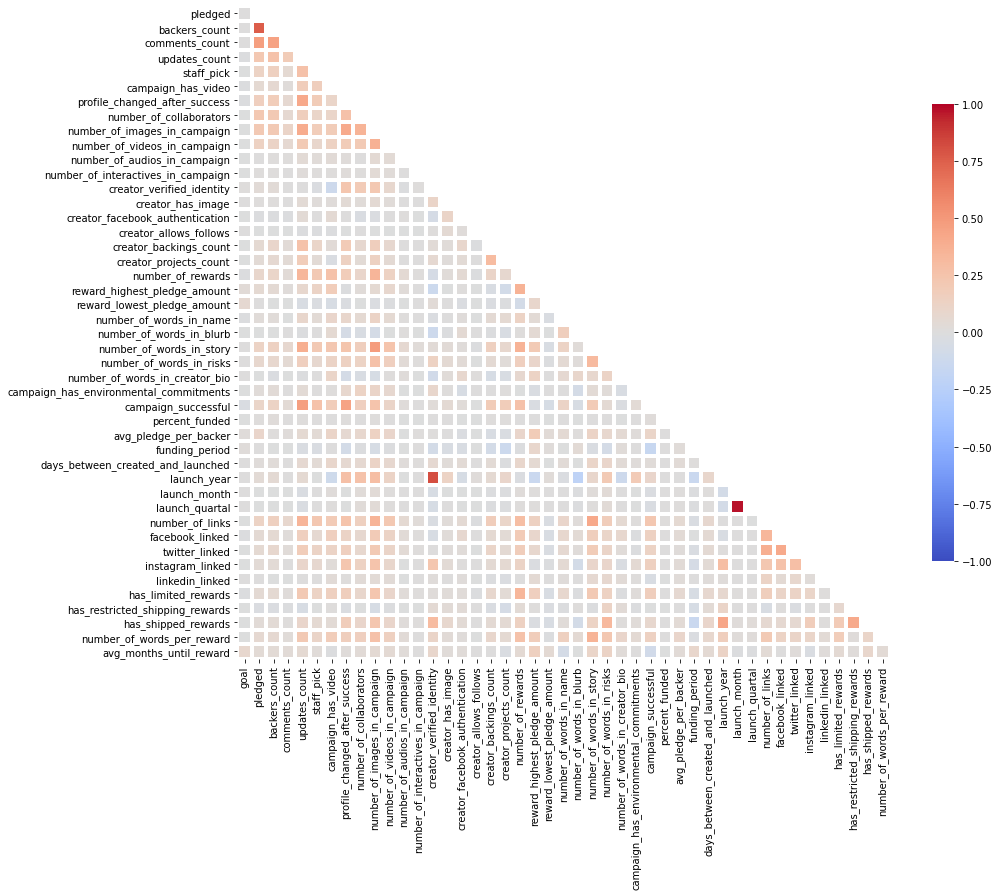

In [ ]:
# Get correlation matrix
corr = kickstarter_df.corr()

# Extract lower triangle of correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Adjust correlation matrix to remove main diagonal
mask = mask[1:, :-1]
corr = corr.iloc[1:,:-1].copy()

# Plot heatmap
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr, mask=mask, annot=False, fmt='.2f', vmin=-1, vmax=1, center=0, cmap="coolwarm", linewidths=3, 
            linecolor='white', square=True, cbar_kws={"shrink": .7});

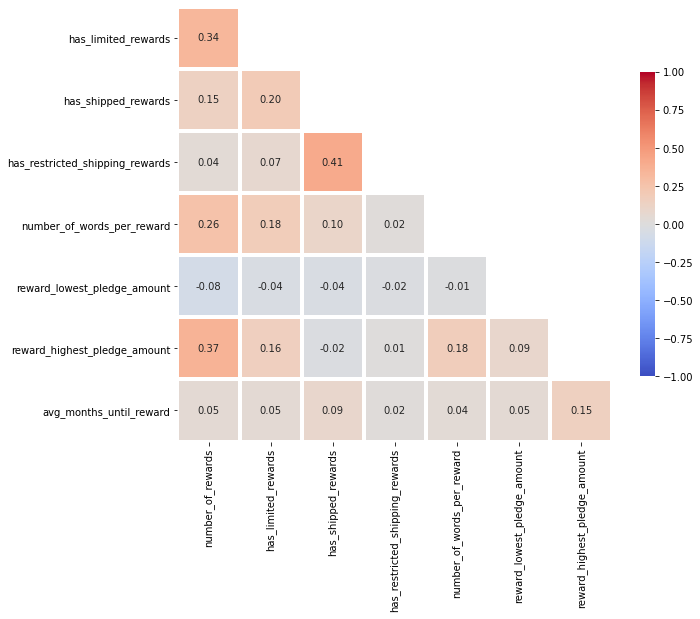

In [ ]:
# Get correlation matrix
corr = kickstarter_df[["number_of_rewards", "has_limited_rewards", "has_shipped_rewards", "has_restricted_shipping_rewards",
                       "number_of_words_per_reward", "reward_lowest_pledge_amount", "reward_highest_pledge_amount",
                       "avg_months_until_reward"]].corr()

# Extract lower triangle of correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Adjust correlation matrix to remove main diagonal
mask = mask[1:, :-1]
corr = corr.iloc[1:,:-1].copy()

# Plot heatmap
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', vmin=-1, vmax=1, center=0, cmap="coolwarm", linewidths=3, 
            linecolor='white', square=True, cbar_kws={"shrink": .7});

In [ ]:
# Drop attribute "reward_average_pledge_amount", since correlated to highest/lowest pledge amount and number of rewards
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["reward_average_pledge_amount"], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 60)
After: (306167, 59)


In [ ]:
# Drop attributes "reward_limit_sum" and "reward_limit_average", since too correlated to number_of_rewards
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["reward_limit_sum", "reward_limit_average"], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 59)
After: (306167, 57)


In [ ]:
# Drop attribute "number_of_delivery_specified_rewards", since it is highly correlated with other reward-based features
# Also, only 18,000 have not a delivery date specified + it would be reflected in months_until_earliest_reward=0
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["number_of_delivery_specified_rewards"], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 57)
After: (306167, 56)


In [ ]:
# Create binary attribute "has_limited_rewards", as the number would be too correlated with "number_of_rewards"
kickstarter_df["has_limited_rewards"] = kickstarter_df.number_of_limited_rewards.apply(lambda x: 1 if x > 0 else 0)
kickstarter_df.has_limited_rewards.value_counts()

True     182881
False    123286
Name: has_limited_rewards, dtype: int64

In [ ]:
# Create binary attribute "has_restricted_shipping_rewards", as the number would be too correlated with "number_of_rewards"
kickstarter_df["has_restricted_shipping_rewards"] = kickstarter_df.number_of_restricted_shipping_rewards.apply(lambda x: 1 if x > 0 else 0)
kickstarter_df.has_restricted_shipping_rewards.value_counts()

False    212639
True      93528
Name: has_restricted_shipping_rewards, dtype: int64

In [ ]:
# Create binary attribute "has_shipped_rewards", as the number would be too correlated with "number_of_rewards"
kickstarter_df["has_shipped_rewards"] = kickstarter_df.number_of_shipped_rewards.apply(lambda x: 1 if x > 0 else 0)
kickstarter_df.has_shipped_rewards.value_counts()

True     221509
False     84658
Name: has_shipped_rewards, dtype: int64

In [ ]:
# Change "number_of_words_in_rewards" to "number_of_words_per_reward" to remove correlation
kickstarter_df["number_of_words_per_reward"] = kickstarter_df["number_of_words_in_rewards"] / kickstarter_df["number_of_rewards"]
kickstarter_df[["number_of_words_per_reward", "number_of_words_in_rewards", "number_of_rewards"]].head()

,number_of_words_per_reward,number_of_words_in_rewards,number_of_rewards
22810934,30.222222,272,9
22821161,36.750000,294,8
22823613,20.500000,41,2
22826244,29.111111,262,9
22835897,44.000000,528,12


In [ ]:
kickstarter_df.number_of_words_per_reward.describe()

count    306109.000000
mean         37.132628
std          24.416382
min           0.000000
25%          20.928571
50%          31.750000
75%          47.000000
max         732.500000
Name: number_of_words_per_reward, dtype: float64

In [ ]:
kickstarter_df.number_of_words_per_reward.fillna(0, inplace=True)

In [ ]:
# Take mean of "months_until_earliest_reward" and "months_until_latest_reward" to remove correlation
kickstarter_df["avg_months_until_reward"] = (kickstarter_df["months_until_earliest_reward"] + kickstarter_df["months_until_latest_reward"])/2
kickstarter_df[["avg_months_until_reward", "months_until_earliest_reward", "months_until_latest_reward"]].head()

,avg_months_until_reward,months_until_earliest_reward,months_until_latest_reward
22810934,37.5,14,61
22821161,5.5,3,8
22823613,4.0,4,4
22826244,5.5,5,6
22835897,5.5,3,8


In [ ]:
kickstarter_df.avg_months_until_reward.describe()

count    306167.000000
mean          5.324895
std           4.313711
min           0.000000
25%           3.000000
50%           4.000000
75%           6.500000
max         120.000000
Name: avg_months_until_reward, dtype: float64

In [ ]:
# Drop correlated reward-based attributes, since correlated to highest/lowest pledge amount and number of rewards
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["number_of_limited_rewards", "number_of_shipped_rewards", "number_of_restricted_shipping_rewards", 
                             "number_of_words_in_rewards", "months_until_earliest_reward", "months_until_latest_reward"], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 57)
After: (306167, 55)


##### Re-Arrange and Rename Attributes:

In [ ]:
# Rename some attributes
kickstarter_df.rename(columns={
    "name" : "title",
    "backers_count" : "number_of_backers",
    "comments_count" : "number_of_comments",
    "updates_count" : "number_of_updates",
    "subcategory" : "category",
    "number_of_words_in_campaign" : "number_of_words",
    "number_of_images_in_campaign" : "number_of_images",
    "number_of_videos_in_campaign" : "number_of_videos",
    "number_of_audios_in_campaign" : "number_of_audios",
    "number_of_interactives_in_campaign" : "number_of_interactives",
    "campaign_has_video" : "campaign_has_demo_video",
    "creator_biography" : "creator_bio",
    "creator_facebook_authentication" : "creator_fb_auth",
    "creator_backings_count" : "number_of_creator_backings",
    "creator_projects_count" : "number_of_creator_projects",
    "reward_highest_pledge_amount" : "highest_pledge_level",
    "reward_lowest_pledge_amount" : "lowest_pledge_level"
}, inplace=True)

In [ ]:
# Re-arrange attributes
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df = kickstarter_df[[
    # Basic Infos
    "campaign_successful", "url",
    # Text Data
    "title", "blurb", "story", "risks", "reward_description", "creator_bio",
    # Project
    "goal", "pledged", "percent_funded", "avg_pledge_per_backer", "number_of_backers", "number_of_comments", "number_of_updates", 
    "number_of_collaborators", "funding_period", "days_between_created_and_launched", "launch_year", "launch_month", "launch_quartal",
    "staff_pick", "campaign_has_video", "campaign_has_environmental_commitments", "profile_changed_after_success", "number_of_images", "number_of_videos",
    "number_of_audios", "number_of_interactives", "number_of_words", "number_of_links",
    # Creator
    "creator_verified_identity", "creator_fb_auth", "creator_has_image",
    "creator_allows_follows", "number_of_creator_backings", "number_of_creator_projects",
    "facebook_linked", "twitter_linked", "instagram_linked", "linkedin_linked",
    # Rewards
    "number_of_rewards", "number_of_words_per_reward", "lowest_pledge_level", "highest_pledge_level", "has_limited_rewards", "has_shipped_rewards",
    "has_restricted_shipping_rewards", "avg_months_until_reward",
    # Categorical Attributes
    "location", "category"
]]
print("After: {}".format(kickstarter_df.shape))

Before: (306167, 51)
After: (306167, 51)


In [ ]:
kickstarter_df.head()

,campaign_successful,url,title,blurb,story,risks,reward_description,creator_bio,goal,pledged,percent_funded,avg_pledge_per_backer,number_of_backers,number_of_comments,number_of_updates,number_of_collaborators,funding_period,days_between_created_and_launched,launch_year,launch_month,launch_quartal,staff_pick,campaign_has_video,campaign_has_environmental_commitments,profile_changed_after_success,number_of_images,number_of_videos,number_of_audios,number_of_interactives,number_of_words,number_of_links,creator_verified_identity,creator_fb_auth,creator_has_image,creator_allows_follows,number_of_creator_backings,number_of_creator_projects,facebook_linked,twitter_linked,instagram_linked,linkedin_linked,number_of_rewards,number_of_words_per_reward,lowest_pledge_level,highest_pledge_level,has_limited_rewards,has_shipped_rewards,has_restricted_shipping_rewards,avg_months_until_reward,location,category
22810934,1,https://www.kickstarter.com/projects/cavinboun...,lights coma action.,a book to tell the story of who i was lights h...,check out the reddit ama and ask me anything....,earlier this year at the twentieth annual writ...,a digital version of the book when it is avai...,in two thousand eleven i suffered a severe tra...,15000.0,18167.88,121,63.971408,284,4,40,0,30,2,2013,10,4,0,1,0,1,0,0,2,0,1126,21,0,0,1,1,7,1,1,1,0,0,9,30.222222,1.0,1000.0,True,True,False,37.5,United States,Publishing_Nonfiction
22821161,0,https://www.kickstarter.com/projects/684178251...,sentio golf putters. feel is the difference,choose the feel you want with our patented flo...,sentio putters feature a unique floating face...,high tech process although we have made severa...,our eternal gratitude. every little bit helps ...,sentio golf is driven to produce the most adva...,50000.0,9707.00,19,236.756098,41,0,4,0,45,102,2015,9,3,0,1,0,0,13,0,0,0,1378,2,1,0,1,1,0,1,0,0,0,0,8,36.750000,5.0,1417.0,False,True,True,5.5,United States,Design_Product Design
22823613,0,https://www.kickstarter.com/projects/123754320...,brainade,we intend to create an online platform for ind...,brainade is meant to be an online platform wh...,there are very few risks involved in this busi...,honorable mention. we will put your name on th...,i am just a college senior trying to help youn...,750.0,1.00,0,1.000000,1,0,0,0,30,13,2017,2,1,0,0,0,0,0,0,0,0,256,0,1,0,1,1,0,1,0,0,0,0,2,20.500000,15.0,30.0,True,False,False,4.0,United States,Technology_Web
22826244,1,https://www.kickstarter.com/projects/impkingco...,horizon anthology,horizon is a one hundred forty four page colle...,update number two. stretch goal number one un...,the main risks we could run into with this pro...,digital enthusiast. the wallpaper pack and a d...,jeremy is a cartoonist and comic book colorist...,7000.0,8955.41,127,31.312622,286,20,16,0,30,234,2014,5,2,1,1,0,0,36,0,0,0,897,22,0,0,1,1,91,3,0,0,0,0,9,29.111111,1.0,300.0,True,True,False,5.5,United States,Comics_Anthologies
22835897,1,https://www.kickstarter.com/projects/alphabets...,the alphabet story children s book,a richly illustrated children s book following...,i have supported myself as a freelance artist...,i have worked with a number of individuals sel...,ebook and more. a free download of the ebook v...,i am a recent transplant to portland or from a...,6000.0,6643.11,110,100.653182,66,1,8,0,28,10,2016,8,3,0,1,0,0,6,0,0,0,712,4,1,0,1,1,4,1,1,0,0,0,12,44.000000,1.0,6000.0,True,True,False,5.5,United States,Publishing_Children's Books


#### Information Leakage Removal:

##### Remove all campaigns with "profile_changed_after_success" = True:

- the data cleaning revealed that the creator can change its profile after it has been successful
- in such cases certain attributes get activated/changed, namely 1) profile_state gets activated and 2) the Graph API name/blurb (i.e. most recent data) has another value than the original datasets
- i.e. get these features from the four datasets and create a final attribute "profile_changed_after_success" that can capture this information leak

In [ ]:
# Import profile_state from Berkeley Dataset
kickstarter_berkeley_df = pd.read_csv("02_Data Collection/Kickstarter_Berkeley.csv", index_col=0)
kickstarter_berkeley_df = kickstarter_berkeley_df[["profile_state"]]
kickstarter_df = kickstarter_df.join(kickstarter_berkeley_df, how="left")
kickstarter_df.rename(columns={"profile_state":"berkeley_profile_state"}, inplace=True)

In [ ]:
# Import graph_name and graph_blurb from Berkeley Graph API Dataset
kickstarter_graph_berkeley_df = pd.read_csv("02_Data Collection/Kickstarter_Graph_API_Berkeley.csv", index_col=0)
kickstarter_graph_berkeley_df.set_index("graph_pid", inplace=True)
kickstarter_graph_berkeley_df = kickstarter_graph_berkeley_df[~kickstarter_graph_berkeley_df.index.duplicated(keep='first')]
kickstarter_graph_berkeley_df = kickstarter_graph_berkeley_df[["graph_profile_name", "graph_profile_blurb"]]
kickstarter_graph_berkeley_df.rename(columns={"graph_profile_name":"graph_berkeley_profile_name", "graph_profile_blurb":"graph_berkeley_profile_blurb"},inplace=True)
kickstarter_df = kickstarter_df.join(kickstarter_graph_berkeley_df, how="left")

In [ ]:
# Import profile_state from Webrobots Dataset
kickstarter_webrobots_df = pd.read_csv("02_Data Collection/Kickstarter_Webrobots.csv", index_col=0)
kickstarter_webrobots_df.set_index("id", inplace=True)
kickstarter_webrobots_df = kickstarter_webrobots_df[["profile"]]
kickstarter_webrobots_df["profile_state"] = kickstarter_webrobots_df.profile.apply(lambda x: re.search("\"state\":\"(.*?)\",", x).group(1) if pd.isnull(re.search("\"state\":\"(.*?)\",", x))==False else None)
kickstarter_webrobots.drop(columns=["profile"], inplace=True)
kickstarter_webrobots_df.rename(columns={"profile_state":"webrobots_profile_state"}, inplace=True)
kickstarter_df = kickstarter_df.join(kickstarter_webrobots_df, how="left")

In [ ]:
# Import graph_name and graph_blurb from Webrobots Graph API Dataset
kickstarter_graph_webrobots_df = pd.read_csv("02_Data Collection/Kickstarter_Graph_API_Webrobots.csv", index_col=0)
kickstarter_graph_webrobots_df.set_index("graph_pid", inplace=True)
kickstarter_graph_webrobots_df = kickstarter_graph_webrobots_df[~kickstarter_graph_webrobots_df.index.duplicated(keep='first')]
kickstarter_graph_webrobots_df = kickstarter_graph_webrobots_df[["graph_profile_name", "graph_profile_blurb"]]
kickstarter_graph_webrobots_df.rename(columns={"graph_profile_name":"graph_webrobots_profile_name", "graph_profile_blurb":"graph_webrobots_profile_blurb"}, inplace=True)
kickstarter_df = kickstarter_df.join(kickstarter_graph_webrobots_df, how="left")

In [ ]:
# Create final attribute "profile_changed_after_success"
kickstarter_df["profile_changed_after_success"] = kickstarter_df.apply(lambda x: True if 
                                                        (x["berkeley_profile_state"]==True) |
                                                        (x["webrobots_profile_state"]==True) |
                                                        (pd.isnull(x["graph_berkeley_profile_name"])==False) |
                                                        (pd.isnull(x["graph_berkeley_profile_blurb"])==False) |
                                                        (pd.isnull(x["graph_webrobots_profile_name"])==False) |
                                                        (pd.isnull(x["graph_webrobots_profile_blurb"])==False) |
                                                        (x["profile_changed_after_success"]==True) else False, axis=1)
kickstarter_df.profile_changed_after_success.value_counts()

False    269551
True      45842
Name: profile_changed_after_success, dtype: int64

In [ ]:
# Delete profile-based attributes, since not needed anymore
kickstarter_df.drop(columns=["berkeley_profile_state", "graph_berkeley_profile_name",
                            "graph_berkeley_profile_blurb", "webrobots_profile_state", 
                            "graph_webrobots_profile_name", "graph_webrobots_profile_blurb"], inplace=True)

In [ ]:
# Status Before
print(kickstarter_df.shape)
kickstarter_df.campaign_successful.value_counts()

(306167, 51)


0    164990
1    141177
Name: campaign_successful, dtype: int64

In [ ]:
# Remove all instances with "profile_changed_after_success" = True
remove_index = kickstarter_df[kickstarter_df.profile_changed_after_success==1].index
kickstarter_df.drop(index=remove_index, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Status After
print(kickstarter_df.shape)
kickstarter_df.campaign_successful.value_counts()

(261455, 51)


0    164990
1     96465
Name: campaign_successful, dtype: int64

In [ ]:
# Drop "profile_changed_after_success", since not needed anymore
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["profile_changed_after_success"], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250670, 51)
After: (250670, 50)


##### Remove campaigns with leaking phrases within the first words of their campaign:

In [ ]:
kickstarter_df.number_of_words.describe()

count    261455.000000
mean        748.408847
std         590.144598
min           0.000000
25%         362.000000
50%         584.000000
75%         946.000000
max       12442.000000
Name: number_of_words, dtype: float64

In [ ]:
# Construct a custom attribute "first_words_of_campaign", which contains the title, blurb, and 25% of the story text (max. 100 words)
kickstarter_df["first_words_of_campaign"] = kickstarter_df.apply(lambda x: x["title"] + " " + x["blurb"] + " " + " ".join(x["story"].split()[0:min(100,round(x["number_of_words"]*0.25))]), axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
tmp = kickstarter_df.first_words_of_campaign.apply(lambda x: len(x.split()))
tmp.describe()

count    261455.000000
mean        114.943956
std          22.444192
min           0.000000
25%         111.000000
50%         124.000000
75%         129.000000
max         171.000000
Name: first_words_of_campaign, dtype: float64

In [ ]:
with pd.option_context("max_colwidth", None):
    display(kickstarter_df[["title", "blurb", "story", "first_words_of_campaign"]].sample(1))

,title,blurb,story,first_words_of_campaign
433030123,it is a long story a radio play podcast,a radio play with three exciting serial stories performed monthly for a live audience and recorded as a podcast.,hi i am patricia middleton. i love theatre and live performances. you may have seen me around. i have been in talent shows doing movie parodies i have written. i have enjoyed acting in and writing and directing melodramas i have done play readings and i have performed in plays. it is a lot of fun to bring a story to life from a spark of idea to a full fledged production. i enjoy clean smart humor and i have an exciting idea for something that mixes old and new together. a radio play. what is a radio play. it is a live performance where all the actors have a script in hand. there is music and sound effects to create the setting but the rest is left up to your imagination just like the old time radio dramas. it is a lot of fun for the audience and does not take as much time for a cast and crew to build a set sew a costume or two memorize lines etc. i would like to bring in a slightly more modern theatrical approach aspect to this performance it by recording it in front of our a live audience so that it can be shared in a podcast format with the world rest of you. and it is not just one story it is three. the first part will be the epic adventures of sir gilbert the gallant and his faithful squire manfred. in sir gilbert s quest to bring light to the dark ages there are encounters with dragons and unicorns and leprechauns and magical objects and damsels in distress. the second saga is centered around sue and lloyd an older couple that have seen a lot in life and do not mind telling you all about it. sue is a wise caring woman who puts up with okay likes okay loves her goofy fun loving bad joke telling husband lloyd. they may live in an idyllic small town but big problems seem to find their front porch pretty often. the third segment follows dr. dorothy reynolds who is a doctor in space. in the future when humans and aliens work side by side to colonize other planets there is a great need for someone to bring healing and hope to the space pioneers. along with facing the harsh environment she learns not every human or alien is what they seem.there are mysteries and secrets in every orbit. sounds fun right. what if i told you we would do all three stories each running about twenty minutes in length so that we had a full hour long show not just once but once a month. i want to gather a group of actors find musicians to create original music and sound effects and put it all together in a great venue for you to enjoy. i am initially launching this and asking those involved along with myself to commit to three performances one each month in early two thousand sixteen. what i need is an investment. having a venue and actors and musicians and a crew and advertising and technical equipment and investing time into writing takes capital. i have figured that it will take at least approximately a thousand dollars to put on each show. ideally this will run every month but for now i have set a goal to do three consecutive shows and that takes my total to three thousand dollars. so my friends i need your help. if you also believe that there should be more smart clean fun in the world i am asking for your assistance in getting this venture started. i bet you are wondering what is in it for me. well i am glad you asked. for a donation of dollar twenty five you will receive two tickets to the premiere event and a producer credit. for dollar seventy five you will receive two tickets to each of the three events a producer credit and be able to take a picture with the entire cast on stage. of course you are welcome to donate any amount every dollar helps. if you are not able to come to the shows consider them as a gift for someone you know in the wichita area or let me know and i will donate them to those who may not otherwise be able to purchase tic

In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains("stretch goal")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (261455, 52)
After: (257189, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"update ")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (257189, 52)
After: (254580, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"update\.")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (254580, 52)
After: (252749, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"reached our target")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (252749, 52)
After: (252735, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"reached our goal")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (252735, 52)
After: (252493, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"campaign was successful")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (252493, 52)
After: (252484, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"project was successful")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (252484, 52)
After: (252474, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"we did it")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (252474, 52)
After: (252201, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"we made it")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (252201, 52)
After: (252032, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"goal reached")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (252032, 52)
After: (251996, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"target reached")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251996, 52)
After: (251994, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"reached our funding")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251994, 52)
After: (251970, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"hit our goal")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251970, 52)
After: (251897, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"hit our target")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251897, 52)
After: (251874, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"goal has been met")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251874, 52)
After: (251851, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"goal has been reached")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251851, 52)
After: (251829, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"target has been reached")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251829, 52)
After: (251827, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"we were successfully funded")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251827, 52)
After: (251825, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"we have been successful")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251825, 52)
After: (251808, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"we got funded")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251808, 52)
After: (251807, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"missed the campaign")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251807, 52)
After: (251779, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"missed out the campaign")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251779, 52)
After: (251778, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"missed out on the campaign")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251778, 52)
After: (251772, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"missed the kickstarter")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251772, 52)
After: (251727, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"missed out on the kickstarter")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251727, 52)
After: (251713, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"who pledged")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251713, 52)
After: (251641, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"new goal")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251641, 52)
After: (251461, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"new target")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251461, 52)
After: (251450, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"new funding")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251450, 52)
After: (251434, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"passed our goal")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251434, 52)
After: (251419, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"passed our target")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251419, 52)
After: (251418, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"passed our funding")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251418, 52)
After: (251416, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"exceeded our goal")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251416, 52)
After: (251405, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"exceeded our funding")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251405, 52)
After: (251404, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"reached the funding")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251404, 52)
After: (251396, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"reached the goal")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251396, 52)
After: (251370, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"reached the target")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251370, 52)
After: (251362, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"passed the goal")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251362, 52)
After: (251360, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"reached its target")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251360, 52)
After: (251358, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"reached its goal")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251358, 52)
After: (251353, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"reached its funding")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251353, 52)
After: (251350, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"who has pledged")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251350, 52)
After: (251327, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"who have pledged")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251327, 52)
After: (251311, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"already raised")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251311, 52)
After: (251255, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"already pledged")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251255, 52)
After: (251225, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"only \b[^s]+?\b days left")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251225, 52)
After: (251187, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"only \b[^s]+?\b weeks left")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251187, 52)
After: (251185, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"only \b[^s]+?\b hours left")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251185, 52)
After: (251170, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"you did it")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251170, 52)
After: (251141, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"missed this campaign")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251141, 52)
After: (251137, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"missed this kickstarter")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251137, 52)
After: (251130, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"missed this project")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251130, 52)
After: (251126, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"funded on")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251126, 52)
After: (251046, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"new pledge")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251046, 52)
After: (251013, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"new reward")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (251013, 52)
After: (250815, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"failed to reach")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250815, 52)
After: (250810, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"kickstarter failed")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250810, 52)
After: (250805, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"kickstarter has failed")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250805, 52)
After: (250804, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"project has failed")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250804, 52)
After: (250803, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"did not reach")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250803, 52)
After: (250725, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"was not successful")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250725, 52)
After: (250710, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"were not successful")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250710, 52)
After: (250707, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"missed the funding")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250707, 52)
After: (250699, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"campaign was unsuccessful")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250699, 52)
After: (250695, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"was not reached")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250695, 52)
After: (250694, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"we did not make it")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250694, 52)
After: (250679, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"rewards added")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250679, 52)
After: (250670, 52)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
with pd.option_context("max_colwidth", None):
    print(len(kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"pledge added")==True]))
    print(kickstarter_df[kickstarter_df.first_words_of_campaign.str.contains(r"pledge added")==True].story.head(50))

0
Series([], Name: story, dtype: object)


In [ ]:
# Drop attribute "first_words_of_campaign", since not needed anymore
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=["first_words_of_campaign"], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250670, 52)
After: (250670, 51)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Unserious Campaign Removal:

##### Remove all instances that have an extremely low number of characters

In [ ]:
# Check for outliers, which nearly don't have any characters
print(len(kickstarter_df[kickstarter_df.title.str.len()+kickstarter_df.blurb.str.len()+kickstarter_df.story.str.len()+kickstarter_df.risks.str.len()<100]))
with pd.option_context("max_colwidth", None):
    print(kickstarter_df[kickstarter_df.title.str.len()+kickstarter_df.blurb.str.len()+kickstarter_df.story.str.len()+kickstarter_df.risks.str.len()<100].url.head(5))

128
28612396     https://www.kickstarter.com/projects/1843389538/extra-virgin-olive-oil-from-the-foothills-of-olymp
30552420             https://www.kickstarter.com/projects/17844193/join-the-revolution-and-produce-the-debut-ep
104167092              https://www.kickstarter.com/projects/290825531/a-fellow-of-infinite-jest-get-to-know-him
131597427    https://www.kickstarter.com/projects/liquidfusion/fund-vintage-siemens-compressor-restoration-unit
141748298                             https://www.kickstarter.com/projects/goforthcreativity/fairytale-carousel
Name: url, dtype: object


In [ ]:
# Remove all campaigns with title+blurb+story+risks < 100 characters
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.title.str.len()+kickstarter_df.blurb.str.len()+kickstarter_df.story.str.len()+kickstarter_df.risks.str.len()<100].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250670, 50)
After: (250542, 50)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


##### Remove instances that are likely only created as test

In [ ]:
# Remove instance with the title "please ignore this project"
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(index=[27181880, 132868061, 1426440198], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250500, 50)
After: (250499, 50)


In [ ]:
# Remove instances wich contain the word "cancelled"
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.title.str.contains("cancelled")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250540, 50)
After: (250533, 50)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Remove instances wich contain the word "canceled"
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.title.str.contains("canceled")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250533, 50)
After: (250529, 50)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Remove instances wich contain the word "postpone"
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.title.str.contains("postpone")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250529, 50)
After: (250528, 50)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Remove instances wich contain the word "funded"
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.title.str.contains(" funded[\.\s]")==True].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250528, 50)
After: (250500, 50)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Delete projects with creator_bio=="none" (are deleted creator profiles)
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.creator_bio=="none"].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250499, 50)
After: (250492, 50)


In [ ]:
# Delete projects with creator_bio=="test" (are deleted creator profiles)
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.creator_bio=="test"].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250492, 50)
After: (250490, 50)


##### Remove instances that are not considered as serious campaigns

In [ ]:
# Remove all campaigns with goal > $1,000,000, which have not been at least 1% funded (are not considered as serious campaigns)
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[(kickstarter_df.goal>1000000) & (kickstarter_df.percent_funded==0)].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (250490, 50)
After: (249831, 50)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Remove certain outliers with extremely high goal manually
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(index=[1887558032], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (249831, 50)
After: (249830, 50)


In [ ]:
# Remove all campaigns with goal < $100 (are not considered as serious attempts)
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.goal<100].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (249830, 50)
After: (247053, 50)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Remove all campaigns with percent_funded > 5,000 (as the funding goal was set extremely unrealistic)
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[(kickstarter_df.percent_funded>5000)].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (247053, 50)
After: (246944, 50)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Remove all projects with an average pledge amount > $3,000 per backer, as these are considered as outliers
print("Before: {}".format(kickstarter_df.shape))
remove_index = kickstarter_df[kickstarter_df.avg_pledge_per_backer>3000].index
kickstarter_df.drop(index=remove_index, inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (246944, 50)
After: (246891, 50)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Replace negative number of comments through 0
kickstarter_df.loc[kickstarter_df.number_of_comments<0, "number_of_comments"] = 0

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


#### Create Final Datasets:

##### Dataset for EDA (Including Leaking Features):

In [ ]:
print(kickstarter_df.shape)
print(len(kickstarter_df.index.unique()))
kickstarter_df.head(1)

(246891, 50)
246891


,campaign_successful,url,title,blurb,story,risks,reward_description,creator_bio,goal,pledged,percent_funded,avg_pledge_per_backer,number_of_backers,number_of_comments,number_of_updates,number_of_collaborators,funding_period,days_between_created_and_launched,launch_year,launch_month,launch_quartal,staff_pick,campaign_has_video,campaign_has_environmental_commitments,number_of_images,number_of_videos,number_of_audios,number_of_interactives,number_of_words,number_of_links,creator_verified_identity,creator_fb_auth,creator_has_image,creator_allows_follows,number_of_creator_backings,number_of_creator_projects,facebook_linked,twitter_linked,instagram_linked,linkedin_linked,number_of_rewards,number_of_words_per_reward,lowest_pledge_level,highest_pledge_level,has_limited_rewards,has_shipped_rewards,has_restricted_shipping_rewards,avg_months_until_reward,location,category
22821161,0,https://www.kickstarter.com/projects/684178251...,sentio golf putters. feel is the difference,choose the feel you want with our patented flo...,sentio putters feature a unique floating face...,high tech process although we have made severa...,our eternal gratitude. every little bit helps ...,sentio golf is driven to produce the most adva...,50000.0,9707.0,19,236.756098,41,0,4,0,45,102,2015,9,3,0,1,0,13,0,0,0,1378,2,1,0,1,1,0,1,0,0,0,0,8,36.75,5.0,1417.0,False,True,True,5.5,United States,Design_Product Design


In [ ]:
kickstarter_df.to_csv("04_Final Datasets/Kickstarter_EDA.csv")

##### Dataset: Information Leaks (for Ablation Analysis)

In [ ]:
# Extract Dataset with information leaks
leak_df = kickstarter_df[["campaign_successful", "pledged", "number_of_backers", "number_of_comments", "number_of_updates", "launch_year"]]
print(leak_df.shape)
print(len(leak_df.index.unique()))
leak_df.head(1)

(246891, 6)
246891


,campaign_successful,pledged,number_of_backers,number_of_comments,number_of_updates,launch_year
22821161,0,9707.0,41,0,4,2015


In [ ]:
# Since spotlight is enabled for all successful campaigns and disables for all failed campaigns, I can simply copy "campaign_successful"
leak_df["spotlight"] = leak_df["campaign_successful"]
leak_df.drop(columns=["campaign_successful"], inplace=True)
leak_df.spotlight.value_counts()

0    160514
1     86377
Name: spotlight, dtype: int64

In [ ]:
# Save Leaking Dataset
leak_df.to_csv("04_Final Datasets/Kickstarter_Structured_Information_Leak.csv")

##### Dataset: Structured + Text Data

Attributes to drop:
- url = no predictive value, since singletons
- spotlight = information leak (already removed in preliminary data cleaning)
- pledged = information leak (won't be available at start of campaign)
- percent_funded = information leak (won't be available at start of campaign)
- avg_pledge_per_backer = information leak (won't be available at start of campaign)
- number_of_backers = information leak (won't be available at start of campaign)
- number_of_comments = information leak (won't be available at start of campaign)
- number_of_updates = information leak (won't be available at start of campaign)
- launch_year = information leak; only useful for EDA
- launch_month = I will use the more consolidated launch_quartal

In [ ]:
# Drop attributes that cannot be used as predictors
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df.drop(columns=[
    "url", "percent_funded", "pledged", "avg_pledge_per_backer", "number_of_backers", "number_of_comments", 
    "number_of_updates", "launch_year", "launch_month"
], inplace=True)
print("After: {}".format(kickstarter_df.shape))

Before: (246891, 50)
After: (246891, 41)


In [ ]:
kickstarter_df.to_csv("04_Final Datasets/Kickstarter_Structured_and_Text.csv")

##### Dataset: Only Text Data

In [ ]:
kickstarter_text_df = kickstarter_df[["campaign_successful", "title", "blurb", "story", "risks", 
                                      "reward_description", "creator_bio"]]
print(kickstarter_text_df.shape)
kickstarter_text_df.head()

(246891, 7)


,campaign_successful,title,blurb,story,risks,reward_description,creator_bio
22821161,0,sentio golf putters. feel is the difference,choose the feel you want with our patented flo...,sentio putters feature a unique floating face...,high tech process although we have made severa...,our eternal gratitude. every little bit helps ...,sentio golf is driven to produce the most adva...
22823613,0,brainade,we intend to create an online platform for ind...,brainade is meant to be an online platform wh...,there are very few risks involved in this busi...,honorable mention. we will put your name on th...,i am just a college senior trying to help youn...
22835897,1,the alphabet story children s book,a richly illustrated children s book following...,i have supported myself as a freelance artist...,i have worked with a number of individuals sel...,ebook and more. a free download of the ebook v...,i am a recent transplant to portland or from a...
22845619,1,the gears lp from scratch. with you.,after a year of record label drama we are rais...,everyone meet the gears lp. the gears lp meet...,,a hug. a hug and an advance prior to official ...,king washington is a very intelligent rock n r...
22848517,1,polynesian adventure the board game,polynesian adventure is a fun and educational ...,we wanted to find a fun and educational way t...,,every dollar helps spread the spirit of polyne...,marcus lobendahn is a father friend husband en...


In [ ]:
kickstarter_text_df.to_csv("04_Final Datasets/Kickstarter_Text.csv")

##### Dataset: Only Structured Data

In [ ]:
kickstarter_structured_df = kickstarter_df.drop(columns=["title", "blurb", "story", "risks", 
                                                          "reward_description", "creator_bio"])
print(kickstarter_structured_df.shape)
kickstarter_structured_df.head()

(246891, 35)


,campaign_successful,goal,number_of_collaborators,funding_period,days_between_created_and_launched,launch_quartal,staff_pick,campaign_has_demo_video,campaign_has_environmental_commitments,number_of_images,number_of_videos,number_of_audios,number_of_interactives,number_of_words,number_of_links,creator_verified_identity,creator_fb_auth,creator_has_image,creator_allows_follows,number_of_creator_backings,number_of_creator_projects,facebook_linked,twitter_linked,instagram_linked,linkedin_linked,number_of_rewards,number_of_words_per_reward,lowest_pledge_level,highest_pledge_level,has_limited_rewards,has_shipped_rewards,has_restricted_shipping_rewards,avg_months_until_reward,location,category
22821161,0,50000.0,0,45,102,3,0,1,0,13,0,0,0,1378,2,1,0,1,1,0,1,0,0,0,0,8,36.750000,5.0,1417.0,0,1,1,5.5,United States,Design_Product Design
22823613,0,750.0,0,30,13,1,0,0,0,0,0,0,0,256,0,1,0,1,1,0,1,0,0,0,0,2,20.500000,15.0,30.0,1,0,0,4.0,United States,Technology_Web
22835897,1,6000.0,0,28,10,3,0,1,0,6,0,0,0,712,4,1,0,1,1,4,1,1,0,0,0,12,44.000000,1.0,6000.0,1,1,0,5.5,United States,Publishing_Children's Books
22845619,1,8000.0,0,30,25,3,0,1,0,1,0,0,0,676,3,0,0,1,1,1,1,1,0,0,0,11,64.545455,5.0,5000.0,0,0,0,0.0,United States,Music_Indie Rock
22848517,1,2500.0,0,30,93,2,0,1,0,4,0,0,0,497,3,0,1,1,1,0,1,0,0,0,0,8,45.875000,1.0,250.0,1,0,0,3.0,United States,Games_Tabletop Games


In [ ]:
kickstarter_structured_df.to_csv("04_Final Datasets/Kickstarter_Structured.csv")